In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [12]:
x_test = []
y_test = []
test_dogs_dir = 'downloads/cats_and_dogs_small/test/dogs/'
for i in range(1500,2000):
    img = cv2.imread(test_dogs_dir + 'dog.{}.jpg'.format(i))
    img = cv2.resize(img, dsize=(150, 150), interpolation=cv2.INTER_CUBIC)
    x_test.append(img)
    y_test.append(1)
test_cats_dir = 'downloads/cats_and_dogs_small/test/cats/'
for i in range(1500,2000):
    img = cv2.imread(test_cats_dir + 'cat.{}.jpg'.format(i))
    img = cv2.resize(img, dsize=(150, 150), interpolation=cv2.INTER_CUBIC)
    x_test.append(img)
    y_test.append(0)
x_test = np.array(x_test).astype(np.float32) / 255
y_test = np.array(y_test).astype(np.float32).reshape((-1,1))
print(x_test.shape, y_test.shape)

(1000, 150, 150, 3) (1000, 1)


In [2]:
lr = 1e-4 
epoch = 30
batch_size = 20
steps_per_epoch = 100

In [3]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=[0.8,1], #0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_dir = 'downloads/cats_and_dogs_small/train/' 
shuffle_batch = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Using TensorFlow backend.


Found 2000 images belonging to 2 classes.


In [8]:
import tensorflow as tf
import numpy as np
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(0)

In [9]:
from keras import layers
from keras import models
from keras.applications import VGG16

vgg = VGG16(weights='imagenet',
            include_top=False,
            input_shape=(150, 150, 3))

model = models.Sequential()
model.add(vgg)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation=None))

In [10]:
set_trainable = False
for layer in vgg.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [12]:
model.trainable_weights

[<tf.Variable 'block5_conv1/kernel:0' shape=(3, 3, 512, 512) dtype=float32>,
 <tf.Variable 'block5_conv1/bias:0' shape=(512,) dtype=float32>,
 <tf.Variable 'block5_conv2/kernel:0' shape=(3, 3, 512, 512) dtype=float32>,
 <tf.Variable 'block5_conv2/bias:0' shape=(512,) dtype=float32>,
 <tf.Variable 'block5_conv3/kernel:0' shape=(3, 3, 512, 512) dtype=float32>,
 <tf.Variable 'block5_conv3/bias:0' shape=(512,) dtype=float32>,
 <tf.Variable 'dense_1/kernel:0' shape=(8192, 256) dtype=float32>,
 <tf.Variable 'dense_1/bias:0' shape=(256,) dtype=float32>,
 <tf.Variable 'dense_2/kernel:0' shape=(256, 1) dtype=float32>,
 <tf.Variable 'dense_2/bias:0' shape=(1,) dtype=float32>]

In [11]:
x = model.input 
logits = model.output
y = tf.placeholder(tf.float32, shape=[None,1], name='y')

y_pred = tf.cast(logits>0, tf.float32, name='y_pred') 

entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits) 
loss = tf.reduce_mean(entropy) 
train = tf.train.RMSPropOptimizer(lr).minimize(loss)

correct = ( tf.abs(y-y_pred) < 0.1 )
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [12]:
with tf.Session() as sess:
    init.run()
    #saver.restore(sess, 'save/nn.ckpt')
    
    loss_trace = []
    accuracy_trace = []

    for i in range(epoch):
        print()
        print('epoch {}/{}'.format(i, epoch), end=' ')
        for t, (x_batch, y_batch) in enumerate(shuffle_batch):            
            y_batch = y_batch.reshape((-1,1))                   
            if t == steps_per_epoch:
                break
            feed_dict = {x: x_batch, y: y_batch}
            loss_run, accuracy_run, _ = sess.run([loss, accuracy, train], feed_dict=feed_dict)
            loss_trace.append(loss_run)
            accuracy_trace.append(accuracy_run)
            print(t)

    feed_dict = {x: x_test, y: y_test}
    accuracy_run, y_test_pred = sess.run([accuracy, y_pred], feed_dict=feed_dict)
    
    saver.save(sess, 'save/nn.ckpt')


epoch 0/30 0
1
2
3


KeyboardInterrupt: 

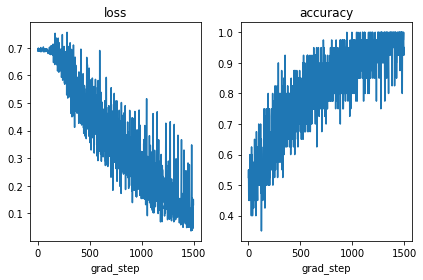

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(loss_trace)
ax2.plot(accuracy_trace)
ax1.set_title('loss')
ax2.set_title('accuracy')
ax1.set_xlabel('grad_step')
ax2.set_xlabel('grad_step')
plt.tight_layout()
plt.show()

In [10]:
print('Test Accuracy :', accuracy_run)

Test Accuracy : 0.708


In [11]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
print(cm)

[[258 242]
 [ 50 450]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


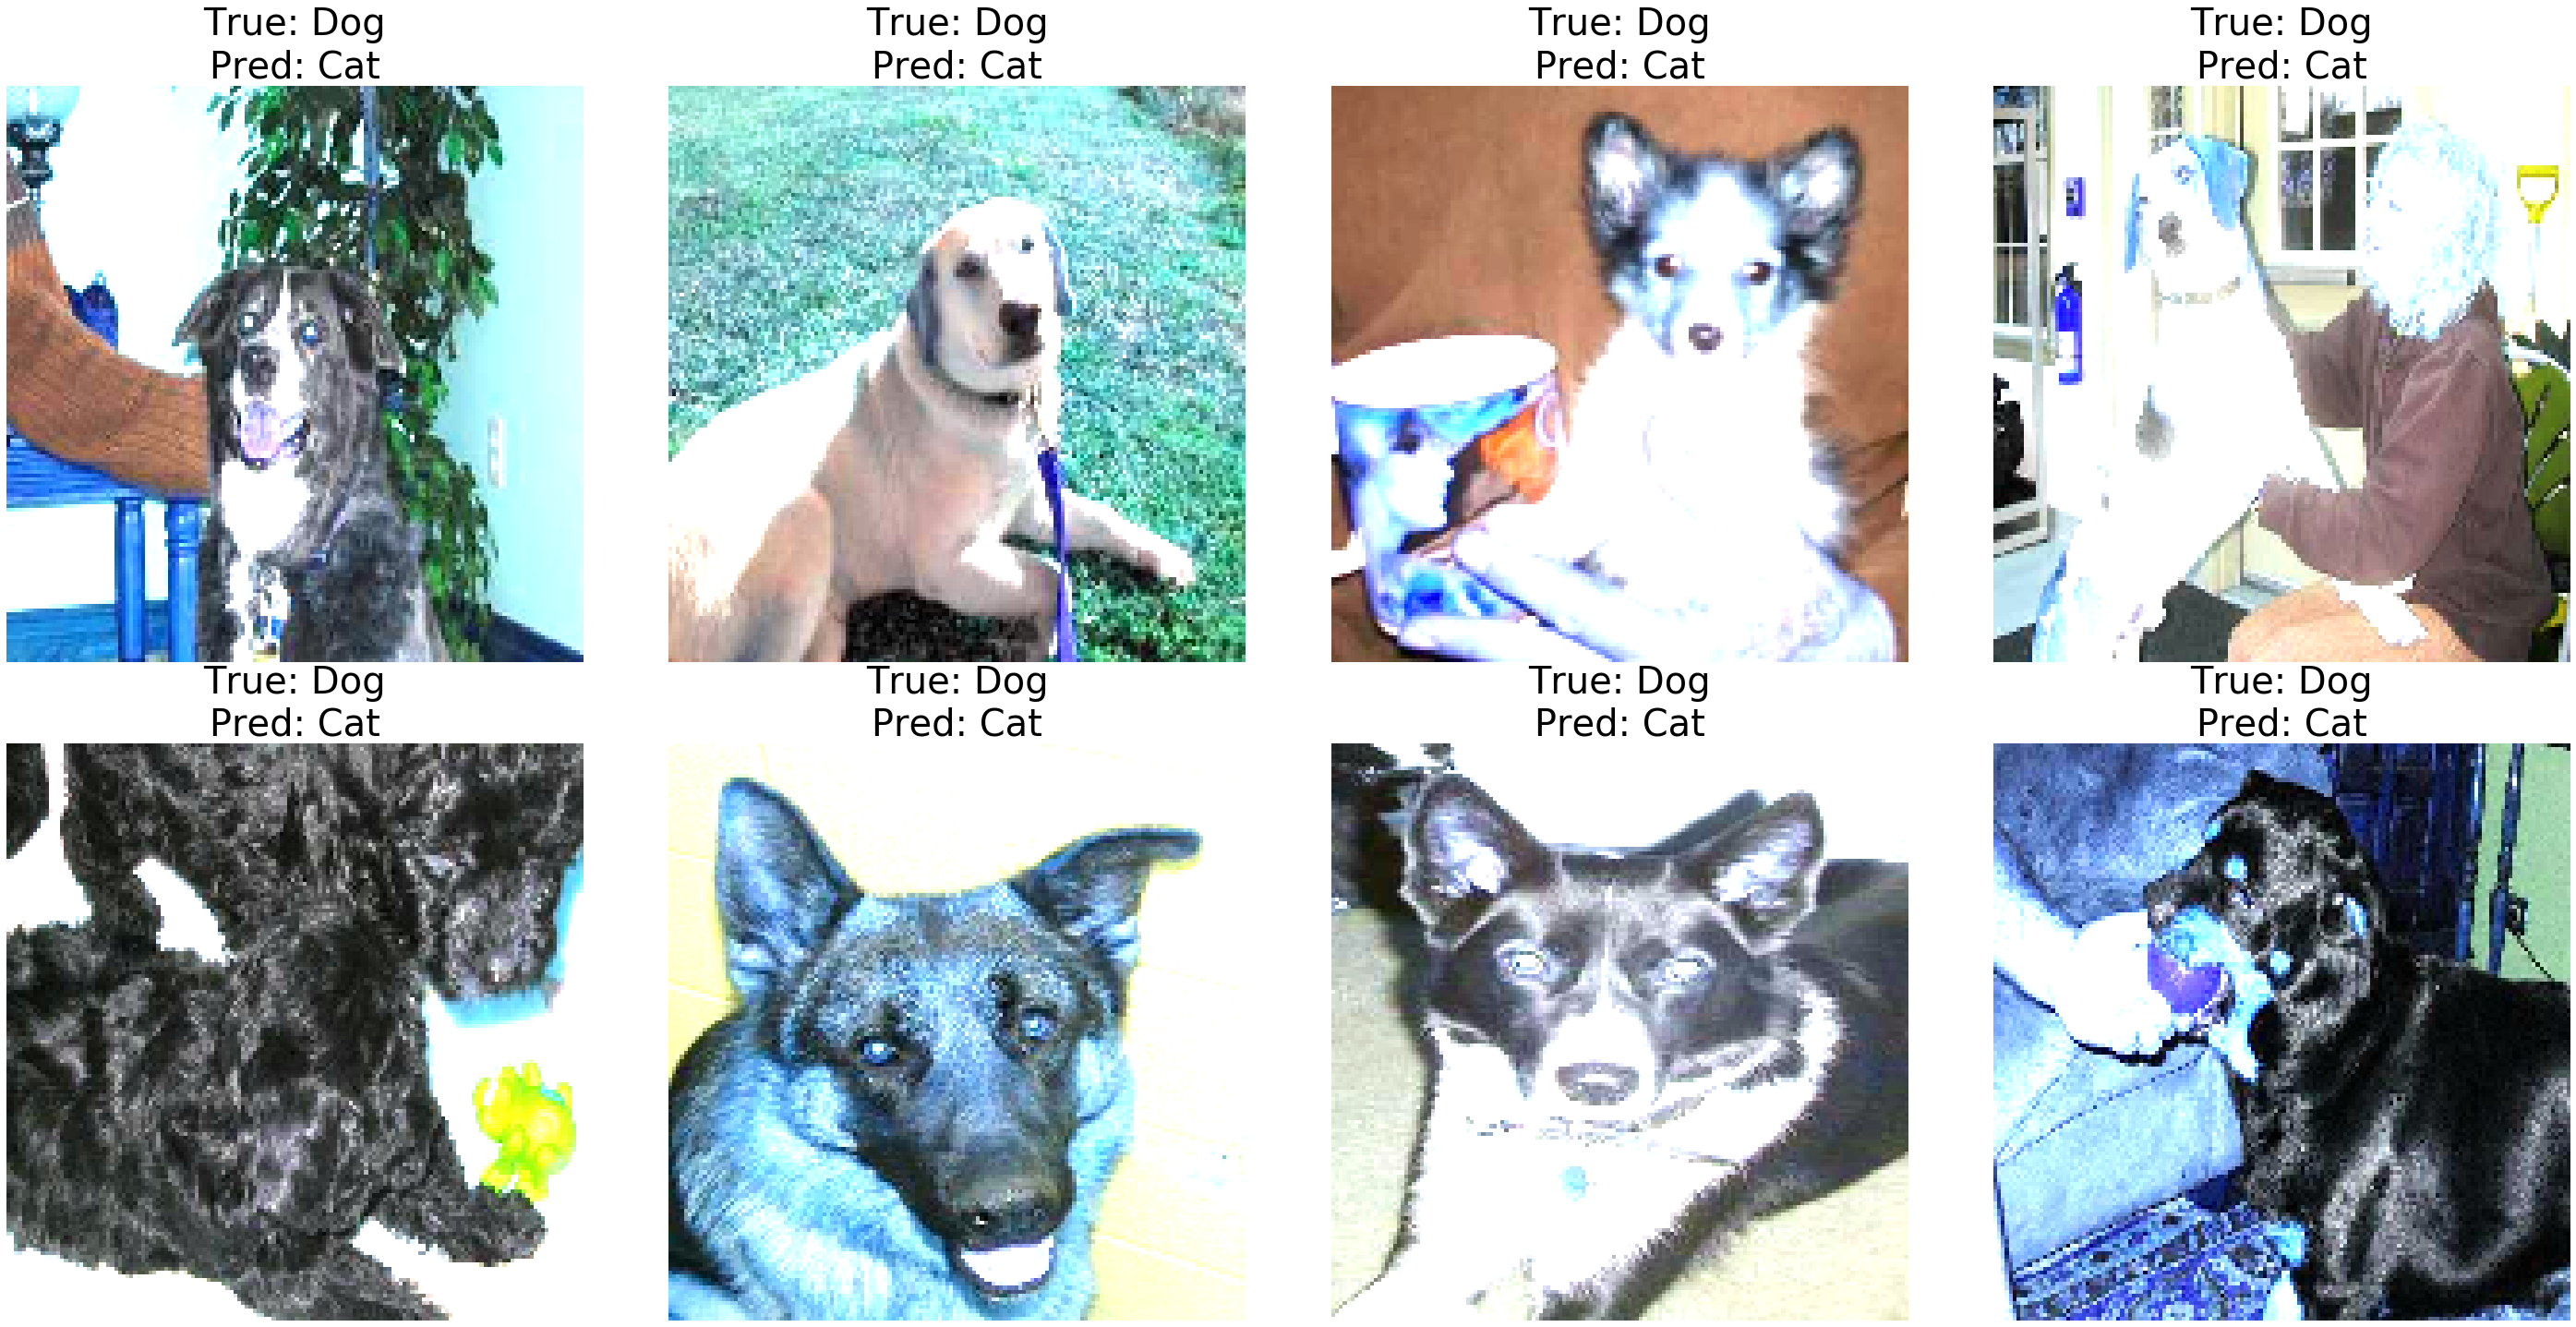

In [12]:
fig, axes = plt.subplots(2, 4, figsize=(40,20))
idx = 0
for ax in axes.reshape((-1,)):
    while True:
        if int(y_test[idx,0])==int(y_test_pred[idx,0]):
            idx += 1
        else:
            ax.imshow((x_test[idx]*255).astype(np.int64))
            if int(y_test[idx,0]) == 1:
                true_label = 'Dog'
                pred_label = 'Cat'
            else:
                true_label = 'Cat'
                pred_label = 'Dog'   
            ax.set_title('True: {}\nPred: {}'.format(true_label, pred_label), fontsize=40)
            ax.axis('off')
            idx += 1
            break
plt.tight_layout()
plt.show()